In [1]:
import sys
sys.path.append('/well/mars/users/uvy786/python')

# if extra packages needed, try !conda install -c channel_name package_name, 
# then !{sys.executable} -m pip install <package_name>

In [2]:
import pandas as pd
import numpy as np
import random
import os
from datatable import fread

import torch
import torch.nn.functional as F
from torch                    import nn
from torch.optim              import SGD
from torch.optim.lr_scheduler import OneCycleLR

from skorch                   import NeuralNetClassifier
from skorch.callbacks         import LRScheduler
from skorch.helper            import DataFrameTransformer

import matplotlib.pyplot as plt
from pyminc.volumes.factory import volumeFromFile

In [3]:
atlas = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_labels_200um.mnc'
anat = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_average_200um.mnc'
mask = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_mask_200um.mnc'

input_data_ROI = '/well/mars/users/uvy786/dl_mouse_human/data/mouse_human/data.ign/MouseExpressionMatrix_ROI_Region67_scaled.csv'
output_data_ROI = '/well/mars/users/uvy786/dl_mouse_human/exps/e1_ae/results.ign/3layers/50_DO_weight_decay_e-1/test/autoencoding/mouse_region_autoencoding.csv'

input_data = (fread(input_data_ROI, header=True).to_pandas())
output_data = (fread(output_data_ROI, header=True).to_pandas())




In [4]:
# Identify columns with label data
indLabels = input_data.columns.str.match('Region')
outLabels = output_data.columns.str.match('Region')
# Extract all other columns, ie the data columns
dfInput = input_data.loc[:,~indLabels]
dfOutput = output_data.loc[:,~outLabels]
# Extract the label column
labelcol = 'Region'
dfLabels = input_data[[labelcol]].copy()
#dfLabels_out = output_data[[labelcol]].copy() same as input

# Change labels into categorical variable
labels = dfLabels.loc[:,labelcol].to_numpy()
dfLabels.loc[:,labelcol] = dfLabels.loc[:,labelcol].astype('category')



In [5]:
# Create instance of the dataframe transformer
dtfx = DataFrameTransformer()

# Fit and transform the input and label dataframes
X_temp = dtfx.fit_transform(dfInput)
y_temp = dtfx.fit_transform(dfLabels)
X_out_temp = dtfx.fit_transform(dfOutput)

# Extract arrays from the dictionnaries
X_in = X_temp['X']
X_out = X_out_temp['X']
y = y_temp[labelcol]


In [6]:
X_diff = X_in - X_out
X_diff_mean = np.mean(X_diff, axis=1)
X_diff_mean.shape

(67,)

In [7]:
#Get gene names
genes = dfInput.columns.to_numpy()
region=input_data['Region'].to_numpy()
#Sorted values
data_sorted, rois_sorted = zip(*sorted(zip(X_diff_mean, region)))



Text(0.5, 1.0, 'Ordered mean input output expression differences')

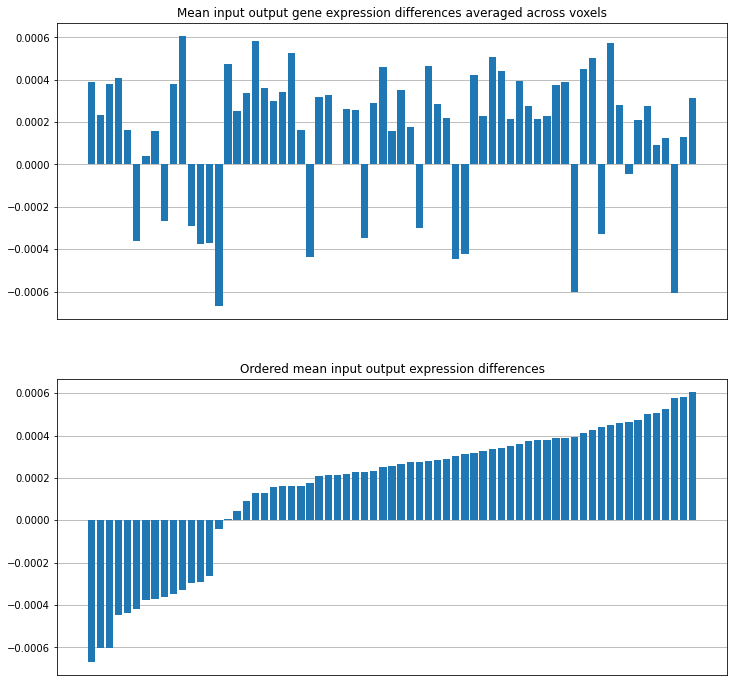

In [8]:

#Array of x values for plotting
x_pos = np.arange(len(rois_sorted))
# Plot the distribution of misclassified voxels, maybe averaged across regions

fig, axes = plt.subplots(2, 1, figsize = (12, 12))

axes[0].grid(zorder = 0, axis = 'y')
axes[0].bar(x_pos, X_diff_mean, zorder = 2)
axes[0].set_xticks([])
axes[0].set_title('Mean input output gene expression differences averaged across voxels')

axes[1].grid(zorder=0, axis='y')
axes[1].bar(x_pos, data_sorted, zorder=2)
axes[1].set_xticks([])
axes[1].set_title('Ordered mean input output expression differences')


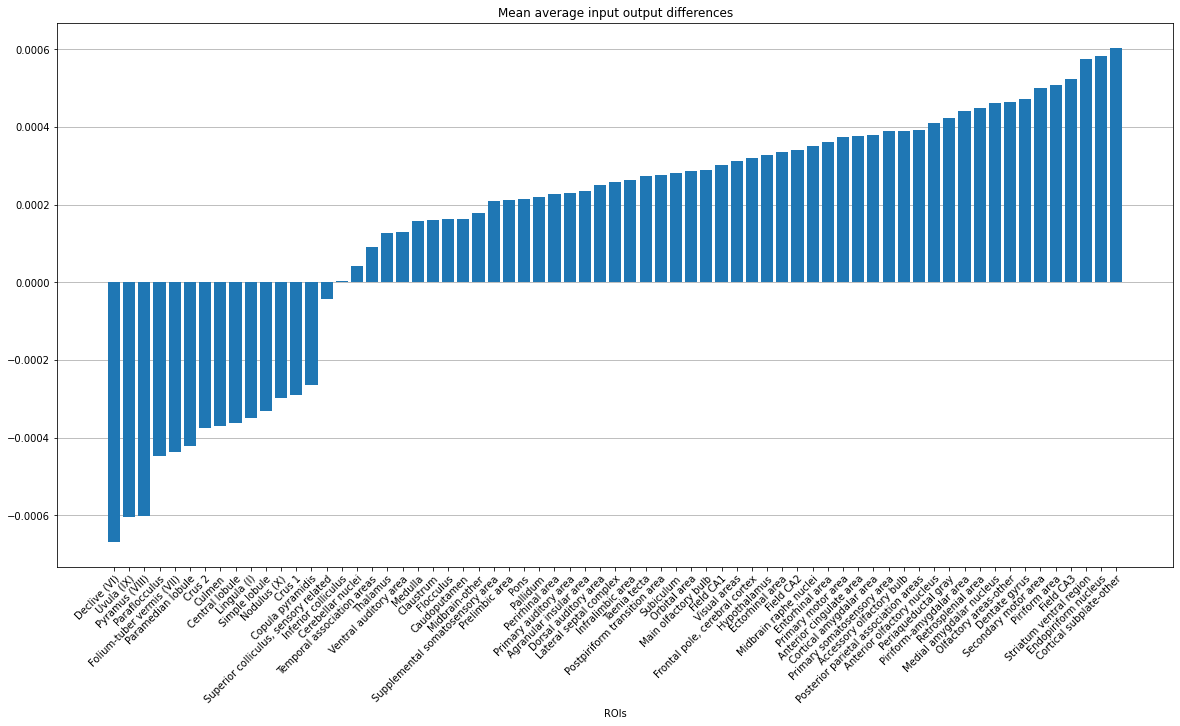

In [9]:
fig, ax = plt.subplots(figsize = (20,10))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos, data_sorted, align = 'center', zorder = 2)
ax.set_xticks(x_pos, rois_sorted, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('ROIs')
ax.set_title('Mean average input output differences')
plt.show()